In [127]:
import math
 
import numpy as np
import pandas as pd
 
from scipy.spatial.distance import euclidean
from numpy import array
from numpy.random import uniform, choice
from pandas import DataFrame
from itertools import combinations

import matplotlib.pyplot as plt
from pylab import plot,show,hist,figure,title

%matplotlib inline

In [161]:
class SimScore(object):

    version = '0.3'
    
    def __init__(self):
        self._n_sim_func = 0
        self.sim_func_container = {}
    
    def load_sim_func(self, _func):
        self.sim_func_container[self._n_sim_func] = _func
        self._n_sim_func = self._n_sim_func + 1
        
    def unload_sim_func(self, index):
        if index in self.sim_func_container:
            del self.sim_func_container[index]
        else:
            print "No similiarity function of index: %d had been loaded prior!" % index 
    
    def update_sim_func(self, _func, index):
        if index not in self.sim_func_container:
            self.load_sim_func(_func)
        else:
            self.sim_func_container[index] = _func

    def cal_sim(self, a, b, index):
        """ Calcuate the distance between (a, b) with
            specified distance function
        """
        if index not in self.sim_func_container:
            err_msg = "Referred similiarity score function is not defined"
            raise ValueError(err_msg)
        return self.sim_func_container[index](a, b)
 
 
class WeightedEuclidean(object):

    version = '0.1'

    def __init__(self, weights=None):
        if weights is None:
            weights = [1] 
        self.weights = weights

    def get_score(self, a, b):
        w = [0] * len(a)
        w[:len(self.weights)] = self.weights
        w_a = [i * j * 1.0 for i, j in zip(a, w)]
        w_b = [i * j * 1.0 for i, j in zip(b, w)]
        return euclidean(w_a, w_b)


class UserBatch(object):

    version = '0.3'
    
    def __init__(self):
        self.users = None            # DataFrame store users profile ["ID", "Taste_Index", "x1" ... "xn"]
        self.all_user_id = None      # list keeps all user_id occuring in users (DataFrame)
        self.friends = None          # data-frame store all friendships [(a, b), a, b]
        self.all_distance = None     # all pair-wise distance
        self.sim_scorer = None       # similarity score function container
        self.dist_cal_counter = 0    # track the update of distance calcualtion
        self.scorer_load_counter = 0 # track the update of scorer object
    
    def load_users(self, x):
        #if isinstance(x, DataFrame) or isinstance(x, numpy.ndarray):
        self.users = x
        self.all_user_id = [uid for uid in self.users["ID"]]
        
    def load_friends(self, x):
        """ Load friendship dataframe
        """
        self.friends = x
    
    def load_sim_scorer(self, sim_score):
        """ Load the similiarity function into a dictionary
            with automatic assigned index for reference
        """
        self.sim_scorer = sim_score
        if self.scorer_load_counter - self.dist_cal_counter == 0:
            self.scorer_load_counter += 1
            
    def update_sim_scorer(self, sim_score, index):
        """ Update 
        """
    
    def cal_pairwise_distances(self):
        """ Calculate the pairwise distance (A2B & B2A) for all
            possible combinations of users appearent in users data
            frame
        """
        all_combs = combinations(self.all_user_id, 2)
        all_pairs = [p for p in all_combs]
        self.all_distance = DataFrame(index=range(len(all_pairs)), \
        columns = ["pair", "uid_a", "uid_b", "dist_a2b", "dist_b2a"])
 
        if self.scorer_load_counter != self.dist_cal_counter:
            print "Updating pairwise distances...."
            for i, pair in enumerate(all_pairs):
                a, b = pair
                
                a_profile = self.users.ix[self.users.ID == a, 2:].as_matrix()
                a_taste   = list(self.users.ix[self.users.ID == a, 1])[0]
                b_profile = self.users.ix[self.users.ID == b, 2:].as_matrix()
                b_taste   = list(self.users.ix[self.users.ID == b, 1])[0]
            
                dist_a2b  = self.sim_scorer.cal_sim(a_profile, b_profile, a_taste)
                dist_b2a  = self.sim_scorer.cal_sim(a_profile, b_profile, b_taste)
                _row = [(a, b), a, b, dist_a2b, dist_b2a]

                self.all_distance.iloc[i] = _row
            
            self.dist_cal_counter += 1 
            print "Updating is completed!"
            
    def dist_distr_display(self):
        """ Display the distribution of pairwise distance grouped
            by friends and non-friends
        """
        bool_idx  = self.all_distance.pair.apply(lambda x: True if x in list(self.friends.pair) else False)
        nbool_idx = bool_idx.apply(lambda x: not x)
        sim_a2b   = self.all_distance.ix[bool_idx, "dist_a2b"]
        sim_b2a   = self.all_distance.ix[bool_idx, "dist_b2a"]
        diff_a2b  = self.all_distance.ix[nbool_idx, "dist_a2b"]
        diff_b2a  = self.all_distance.ix[nbool_idx, "dist_b2a"]

        ## Visualize the ploting
        plt.figure(1)
        plt.subplot(211)

        plt.title("Distance (A to B) Distribution")
        sim_a2b.hist(color = 'green', alpha = .5, bins = 20)
        diff_a2b.hist(color = 'red', alpha = .5, bins = 20)

        plt.subplot(212)
        plt.title("Distance (B to A)Distribution From B to A")
        sim_b2a.hist(color = 'green', alpha = .5, bins = 20)
        diff_b2a.hist(color = 'red', alpha = .5, bins = 20)
            
    def get_user_profile(self, uid):
        res = self.users.ix[self.users.ID == uid, :].copy()
        return res
    
    def get_user_friends(self, uid):
        pass
        
    def get_user_distance(self, uid):
        row_idx_a = self.all_distance.uid_a == uid
        row_idx_b = self.all_distance.uid_b == uid
        a = list(self.all_distance.ix[row_idx_a, "dist_a2b"])
        b = list(self.all_distance.ix[row_idx_b, "dist_b2a"])
        return a + b

In [198]:
sim_score = SimScore()
 
sim_func01 = WeightedEuclidean([0.5, 0.3, 0.2, 0, 0, 0]).get_score
sim_func02 = WeightedEuclidean([0, 0, 0, 0.5, 0.3, 0.2]).get_score
 
sim_score.load_sim_func(sim_func01)
sim_score.load_sim_func(sim_func02)
 
## ################################# ##
## GENERATE SAMPLE DATA              ##
## ################################# ##
n_sample = 10
## Simulate the profile data
users = DataFrame({"ID": range(n_sample), \
                   "taste": choice([0, 1], n_sample),
                   "x1": uniform(0, 1, n_sample),
                   "x2": uniform(0, 1, n_sample),
                   "x3": uniform(0, 1, n_sample),
                   "x4": uniform(0, 1, n_sample),
                   "x5": uniform(0, 1, n_sample),
                   "x6": uniform(0, 1, n_sample)})

all_users = [ uid for uid in users.ID ]

## Simulate friendship data
all_pairs = [ p for p in combinations(all_users, r=2) ]
## Sampel relationship
samp_idx = choice(range(len(all_pairs)), size = int(len(all_pairs) * .4), replace = False)
samp_pairs = [ all_pairs[i] for i in samp_idx ]
friends_df = DataFrame(index=range(len(samp_pairs)), columns = ["pair", "uid_a", "uid_b"])
## 
for i, p in enumerate(samp_pairs):
    a, b = p
    _row = [p, a, b]
    friends_df.iloc[i, :] = _row
    
del i, p, a, b, _row

Similarity scorer loading count 1
Updating pairwise distances....
Updating is completed!
Distance calculation operation count 1


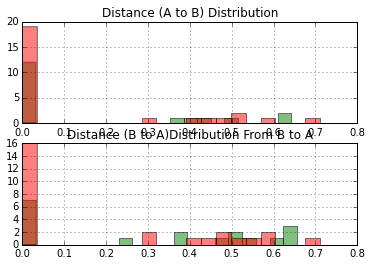

In [199]:
ubatch = UserBatch()
ubatch.load_users(users)
ubatch.load_friends(friends_df)
ubatch.load_sim_scorer(sim_score)
print "Similarity scorer loading count %d" % ubatch.scorer_load_counter
ubatch.cal_pairwise_distances()
print "Distance calculation operation count %d" % ubatch.dist_cal_counter
## display the distribution of distance
ubatch.dist_distr_display()

Similarity scorer loading count 2
Updating pairwise distances....
Updating is completed!
Distance calculation operation count 2


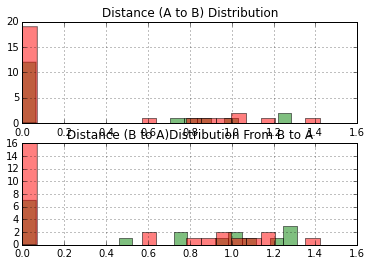

In [200]:
sim_func01 = WeightedEuclidean([1] * 6).get_score
sim_score.update_sim_func(sim_func01, 0)
ubatch.load_sim_scorer(sim_score)
print "Similarity scorer loading count %d" % ubatch.scorer_load_counter
ubatch.cal_pairwise_distances()
print "Distance calculation operation count %d" % ubatch.dist_cal_counter
ubatch.dist_distr_display()

Similarity scorer loading count 3
Updating pairwise distances....
Updating is completed!
Distance calculation operation count 3


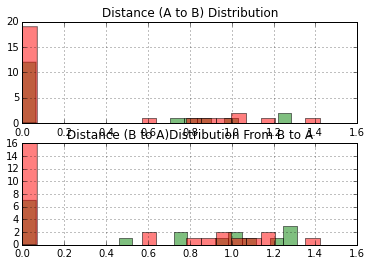

In [201]:
sim_func02 = WeightedEuclidean([0, 0.5, 0.2, 0.1, 0.2, 0]).get_score
sim_score.update_sim_func(sim_func02, 1)
ubatch.load_sim_scorer(sim_score)
print "Similarity scorer loading count %d" % ubatch.scorer_load_counter
ubatch.cal_pairwise_distances()
print "Distance calculation operation count %d" % ubatch.dist_cal_counter
ubatch.dist_distr_display()

In [179]:
## #################################### ##
## Test the sim_score update mechanism  ##
## #################################### ##
sim_score = SimScore()
 
sim_func01 = WeightedEuclidean([0.5, 0.3, 0.2, 0, 0, 0]).get_score
sim_func02 = WeightedEuclidean([0, 0, 0, 0.5, 0.3, 0.2]).get_score
 
sim_score.load_sim_func(sim_func01)
sim_score.load_sim_func(sim_func02)
ubatch.load_sim_scorer(sim_score)
print "********************* Initial ***************************"
dist0 = ubatch.sim_scorer.cal_sim([0] * 6, [1, 0, 0, 1, 1, 1], 0)
dist1 = ubatch.sim_scorer.cal_sim([0] * 6, [1, 0, 0, 1, 1, 1], 1)
print "%d func's score: %.4f" % (0, dist0)
print "%d func's score: %.4f" % (1, dist1)


sim_func01 = WeightedEuclidean([1] * 6).get_score
sim_score.update_sim_func(sim_func01, 0)
ubatch.load_sim_scorer(sim_score)
print "********************* Updated ***************************"
dist0 = ubatch.sim_scorer.cal_sim([0] * 6, [1, 0, 0, 1, 1, 1], 0)
dist1 = ubatch.sim_scorer.cal_sim([0] * 6, [1, 0, 0, 1, 1, 1], 1)
print "%d func's score: %.4f" % (0, dist0)
print "%d func's score: %.4f" % (1, dist1)

********************* Initial ***************************
0 func's score: 0.5000
1 func's score: 0.6164
********************* Updated ***************************
0 func's score: 2.0000
1 func's score: 0.6164


pandas.core.series.Series